In [350]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

pd.set_option('display.max_columns',200)

## (normalized) Time in Posession
Dataset of "2020-2022 Event Data Set" from UNSW 2020-2022 NRL DATA


## 1. Filtering out unnecessary columns-showing only columns with basic identifying info and ball posession-related columns.
##2. Data cleaning: Null handling, data standardization and outlier detection.
(2-1 Null handling was done in previous filtering step, step 1)
(2-2 data standardization: standardized the unit of time to seconds--no need to touch 'half', 'ElapsedMins' as they are just time stamps)
(2-3 outlier detection is not needed for considering overall possession time over ball in games)

In [320]:
## filtering out Posession variables-locational data normalized wrt to the club in possesion-**Posession

#csv_path = 'path_to_"2021 Event Data.csv" from "UNSW 2021 Event Data.zip" '
csv_path = '/Users/june/Downloads/24T3/data3001/2021 Event Data.csv'

def Possession_filter(csv_path):
    df = pd.read_csv(csv_path, low_memory=False)
    possession_col = [
        #match identifying columns
        'MatchId', 'ClubId', 'OppositionId', 
        #Time related data
        'SeqNumber', 'Half', 'ElapsedMins', 'ElapsedSecs','PossessionSecs', 'OppPossessionSecs', 'TotalPossessionSecs',
        #Event data
        'EventCode', 'EventName', 'Set', 'Tackle',
        #possession club/player id
        'InPossessionClubId', 'InPossessionPlayerId',
        #score
        'Score', 'OppScore', 
        #field position data(normalized)
        'XmPhysical', 'YmPhysical', 'XmPossession', 'YmPossession',
        #extra? possession related data
        'ZonePhysical', 'ChannelPhysical', 'SectionPhysical', 'ZonePhysical', 'ChannelPhysical', 'SectionPhysical'
    ]
    df_possession = df[possession_col]
    df_possession = df_possession.dropna() #2-1 Null handling
    return df_possession]
    
#for display in jupyter
display(Possession_filter(csv_path))

#for use
df_possession = Possession_filter(csv_path)

,MatchId,ClubId,OppositionId,SeqNumber,Half,ElapsedMins,ElapsedSecs,PossessionSecs,OppPossessionSecs,TotalPossessionSecs,EventCode,EventName,Set,Tackle,InPossessionClubId,InPossessionPlayerId,Score,OppScore,XmPhysical,YmPhysical,XmPossession,YmPossession,ZonePhysical,ChannelPhysical,SectionPhysical,ZonePhysical,ChannelPhysical,SectionPhysical
0,21111011.0,500005.0,500021.0,10,1,0,4,4.00,0.00,4.00,ENPO,Possession - end,1,0,500005.0,502502.0,0.0,0.0,50.0,34.7,50.0,34.7,39,C,-50,39,C,-50
1,21111011.0,500021.0,500005.0,100,1,0,28,24.06,4.00,28.06,PBNS,PTB - neutral,1,2,500021.0,500584.0,0.0,0.0,67.1,25.8,32.9,44.2,52,L,-70,52,L,-70
2,21111011.0,500005.0,500021.0,1000,1,6,34,92.46,179.28,271.74,MBCS,Metres Before Contact,8,4,500005.0,503450.0,0.0,6.0,43.7,36.0,43.7,36.0,39,C,-50,39,C,-50
3,21111011.0,500021.0,500005.0,10000,2,37,7,1512.52,1378.58,2891.10,MBCS,Metres Before Contact,74,3,500021.0,500598.0,26.0,18.0,21.3,47.5,21.3,47.5,26,R,-30,26,R,-30
4,21111011.0,500021.0,500005.0,10001,2,37,7,1512.53,1378.58,2891.11,OADS,Over advantage line,74,3,500021.0,500598.0,26.0,18.0,21.3,47.5,21.3,47.5,26,R,-30,26,R,-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260064,21111291.0,500014.0,500005.0,9995,2,25,36,1527.50,1345.02,2872.52,MBCS,Metres Before Contact,68,4,500014.0,508062.0,8.0,8.0,41.5,43.5,41.5,43.5,40,R,-50,40,R,-50
2260065,21111291.0,500005.0,500014.0,9996,2,25,36,1345.02,1527.50,2872.52,MBCD,Metres Before Contact by Opp,68,4,500014.0,508062.0,8.0,8.0,41.5,43.5,41.5,43.5,40,R,-50,40,R,-50
2260066,21111291.0,500005.0,500014.0,9997,2,25,36,1345.02,1527.50,2872.52,MBCD,Metres Before Contact by Opp,68,4,500014.0,508062.0,8.0,8.0,41.5,43.5,41.5,43.5,40,R,-50,40,R,-50
2260067,21111291.0,500014.0,500005.0,9998,2,25,36,1527.51,1345.02,2872.53,OADS,Over advantage line,68,4,500014.0,508062.0,8.0,8.0,41.5,43.5,41.5,43.5,40,R,-50,40,R,-50


In [321]:
def get_overall_possession_with_features(df_possession):
    # Group by MatchId and InPossessionClubId, eventcode, eventname - each team, each match
    overall_possession = df_possession.groupby(['MatchId', 'InPossessionClubId', 'EventCode', 'EventName']).agg(
        TotalPossessionTime=('PossessionSecs', 'sum'),
        TotalOpponentPossessionTime=('OppPossessionSecs', 'sum'),
        AverageFieldPositionX=('XmPhysical', 'mean'),
        AverageFieldPositionY=('YmPhysical', 'mean'),
        AverageScore=('Score', 'mean'),
        AverageOppScore=('OppScore', 'mean'),
        PossessionCount=('PossessionSecs', 'count')
    ).reset_index()

    
    #feature 1. posseiontime_diff
    overall_possession['PossessionTime_Diff'] = overall_possession['TotalPossessionTime'] - overall_possession['TotalOpponentPossessionTime']
    
    #feature 2. posseiiontime_field position: total posssssion time * avg filed position gives the effect of controlling the ball in strategic field positions.
    overall_possession['PossessionTime_FieldPosition'] = overall_possession['TotalPossessionTime'] * overall_possession['AverageFieldPositionX']
    
    # Match and club IDs as integers, Eventcode/name str
    overall_possession['MatchId'] = overall_possession['MatchId'].astype(int)
    overall_possession['InPossessionClubId'] = overall_possession['InPossessionClubId'].astype(int)
    overall_possession['EventCode'] = overall_possession['EventCode'].astype(str)
    overall_possession['EventName'] = overall_possession['EventName'].astype(str)
    
    float_cols = ['TotalPossessionTime', 'TotalOpponentPossessionTime', 'AverageFieldPositionX', 
                  'AverageFieldPositionY', 'AverageScore', 'AverageOppScore', 'PossessionCount', 
                  'PossessionTime_Diff', 'PossessionTime_FieldPosition']
    overall_possession[float_cols] = overall_possession[float_cols].astype(float)
    
    return overall_possession

df_possession = Possession_filter(csv_path)
df_overall_possession = get_overall_possession_with_features(df_possession)
df_overall_possession.to_csv('/Users/june/Downloads/24T3/data3001/overall_possession_data.csv', index=False)
df_overall_possession.head()

,MatchId,InPossessionClubId,EventCode,EventName,TotalPossessionTime,TotalOpponentPossessionTime,AverageFieldPositionX,AverageFieldPositionY,AverageScore,AverageOppScore,PossessionCount,PossessionTime_Diff,PossessionTime_FieldPosition
0,21111011,500005,BKCD,Break by opp cause,5275.20,5813.08,40.057143,40.242857,5.142857,21.142857,7.0,-537.88,211309.440000
1,21111011,500005,BKCS,Break cause,5813.08,5275.20,40.057143,40.242857,21.142857,5.142857,7.0,537.88,232855.376000
2,21111011,500005,BLFD,Lost ball forward by opp,1844.08,1537.50,75.066667,36.066667,17.333333,4.000000,3.0,306.58,138428.938667
3,21111011,500005,BLFS,Loses ball forward,1537.50,1844.08,75.066667,36.066667,4.000000,17.333333,3.0,-306.58,115415.000000
4,21111011,500005,CBFN,Colour: Big fend,1285.64,1326.16,53.200000,30.500000,18.000000,26.000000,1.0,-40.52,68396.048000


In [393]:
def filter_by_club(df_overall_possession, club_id):
    club_possession = df_overall_possession[df_overall_possession['InPossessionClubId'] == club_id]
    # Eliminate events that happened by the opponent team
    club_possession = club_possession[~club_possession.apply(lambda row: row.astype(str).str.contains('by opp|by Opp|opp|Opp', case=False, na=False).any(), axis=1)]
    return club_possession
    
df_possession = Possession_filter(csv_path)
df_overall_possession = get_overall_possession_with_features(df_possession)
csv_path2 = '/Users/june/Downloads/24T3/data3001/overall_possession_data.csv'
df_possession2 = pd.read_csv(csv_path2)

club_id = 500005  # Plug the clubID here
club_possession = filter_by_club(df_possession2, club_id)
columns_to_display = [col for col in club_possession.columns if col not in ['MatchId', 'InPossessionClubId', 'TotalOpponentPossessionTime']]
event_possession_per_team = club_possession[columns_to_display]
event_possession_per_team #possession related info on club 500005 only, without 'MatchId', 'InPossessionClubId' columns

,EventCode,EventName,TotalPossessionTime,AverageFieldPositionX,AverageFieldPositionY,AverageScore,AverageOppScore,PossessionCount,PossessionTime_Diff,PossessionTime_FieldPosition
1,BKCS,Break cause,5813.08,40.057143,40.242857,21.142857,5.142857,7.0,537.88,232855.376000
3,BLFS,Loses ball forward,1537.50,75.066667,36.066667,4.000000,17.333333,3.0,-306.58,115415.000000
4,CBFN,Colour: Big fend,1285.64,53.200000,30.500000,18.000000,26.000000,1.0,-40.52,68396.048000
5,CCEX,Colour: Comm. excitement,4816.38,22.283333,37.700000,10.000000,21.000000,6.0,-309.74,107325.001000
7,CLAS,Cleans up (attack),2386.68,53.300000,22.650000,18.000000,26.000000,2.0,-1.12,127210.044000
...,...,...,...,...,...,...,...,...,...,...
97030,TRAS,Try assist,1562.78,2.500000,63.200000,8.000000,14.000000,1.0,-172.14,3906.950000
97031,TRCS,Try cause,7146.96,52.214286,39.657143,8.571429,3.428571,7.0,836.30,373173.411429
97032,TRIS,Try involvement,1561.74,5.800000,53.100000,8.000000,14.000000,1.0,-173.18,9058.092000
97033,TRY,Try,1971.64,50.250000,49.250000,8.000000,10.000000,2.0,-334.66,99074.910000


In [407]:
columns_to_display = [col for col in event_possession_per_team.columns if col not in ['MatchId', 'InPossessionClubId', 'TotalOpponentPossessionTime']]
event_possession_per_team = event_possession_per_team[columns_to_display]

#1-1. Top 10% events by TotalPossessionTime of this team
top_10_percent_possession_time_threshold = event_possession_per_team['TotalPossessionTime'].quantile(0.90)
top_10_percent_possession_time = event_possession_per_team[event_possession_per_team['TotalPossessionTime'] >= top_10_percent_possession_time_threshold]

# Display for top 10% events and top 10 events on PossessionTime(longest)
#display(top_10_percent_possession_time)

# 1-2 Top 10 events of TotalPossessionTime of this team
top_10_possession_time_events_per_club = event_possession_per_team.sort_values(by='TotalPossessionTime', ascending=False).head(10)
display(top_10_possession_time_events_per_club)

,EventCode,EventName,TotalPossessionTime,AverageFieldPositionX,AverageFieldPositionY,AverageScore,AverageOppScore,PossessionCount,PossessionTime_Diff,PossessionTime_FieldPosition
86270,RCVS,Receives,432541.26,51.458425,33.503282,21.557987,7.417943,457.0,115964.28,2.225789e+07
51442,RCVS,Receives,401750.70,49.447727,35.911364,17.713636,0.000000,440.0,112350.42,1.986566e+07
96181,RCVS,Receives,383640.38,48.852358,33.892453,15.400943,2.533019,424.0,118895.74,1.874174e+07
91477,RCVS,Receives,376248.66,45.503667,34.280929,13.144254,0.782396,409.0,51631.58,1.712069e+07
14027,RCVS,Receives,365180.74,50.247772,33.799752,14.415842,4.262376,404.0,70939.22,1.834952e+07
93973,RCVS,Receives,361806.52,51.616010,33.616256,9.453202,7.694581,406.0,32531.84,1.867501e+07
66818,RCVS,Receives,361052.24,50.491479,33.307519,31.593985,12.075188,399.0,145417.18,1.823006e+07
25765,RCVS,Receives,352901.32,45.758128,34.978571,16.295567,13.339901,406.0,47592.26,1.614810e+07
70734,RCVS,Receives,349758.56,49.546954,32.970051,21.451777,8.121827,394.0,63677.58,1.732947e+07
19973,TKES,Tackles - made,345377.60,49.068421,34.751247,7.113573,5.418283,361.0,43085.40,1.694713e+07


In [ ]:
#2. Top 10% events by higest average score
top_10_percent_average_score_threshold = club_possession['AverageScore'].quantile(0.90)

# Filter the rows with AverageScore greater than or equal to the threshold
top_10_percent_average_score = club_possession[club_possession['AverageScore'] >= top_10_percent_average_score_threshold]

# Display the top 10% by AverageScore
print(top_10_percent_average_score)


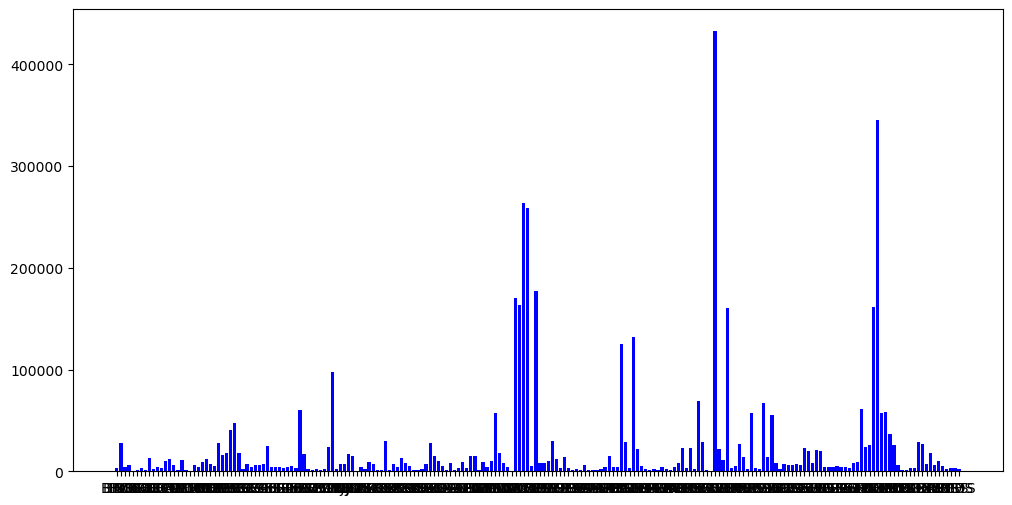

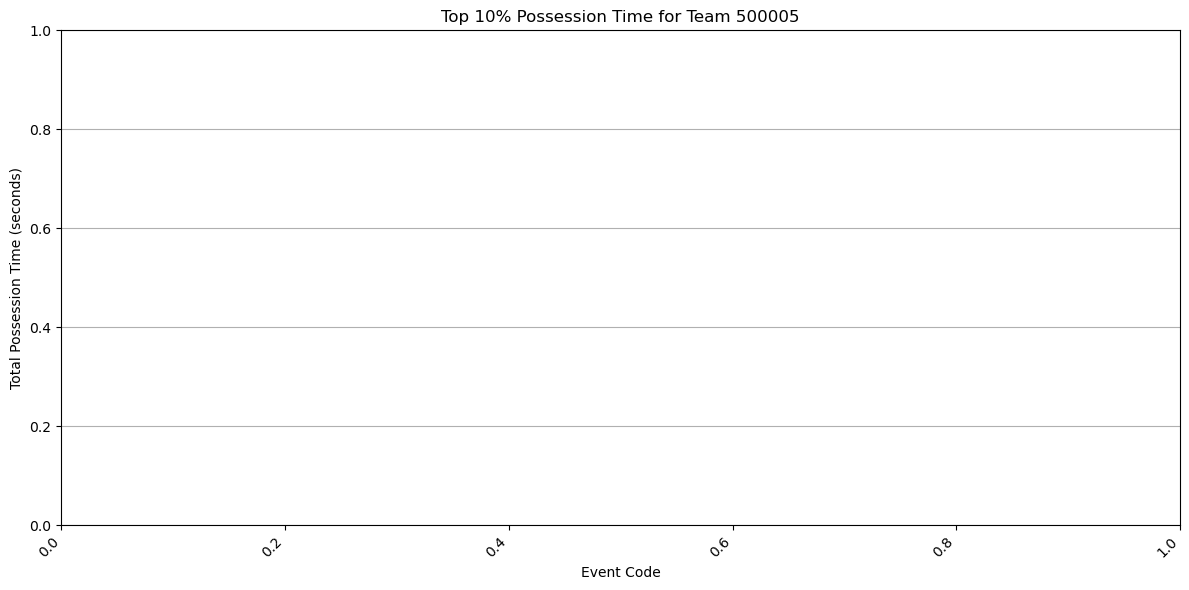

In [356]:
#create a bar table from the above club's games in 2021


#x-axis: EventCode, y-axis: Possession Time in total(throughout 2021)
plt.figure(figsize=(12, 6))
plt.bar(club_possession['EventCode'], club_possession['TotalPossessionTime'], color='b')

#scenario 1
#for team 500005 in 2021, show top 10% events that records longest total possession time

top_10_percent_threshold = club_possession['TotalPossessionTime'].quantile(0.90)
plt.figure(figsize=(12, 6))
top_10_percent_events = club_possession[club_possession['TotalPossessionTime'] >= top_10_percent_threshold]
plt.title('Top 10% Possession Time for Team 500005')
plt.xlabel('Event Code')
plt.ylabel('Total Possession Time (seconds)')
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
def get_team_possession_data(df_possession):
    team_possession = df_possession.groupby(['MatchId', 'InPossessionClubId']).agg(
        TotalPossessionTime=('PossessionSecs', 'sum'),
        TotalOpponentPossessionTime=('OppPossessionSecs', 'sum'),
        AverageFieldPositionX=('XmNormalized', 'mean'),
        AverageFieldPositionY=('YmNormalized', 'mean'),
        AverageScore=('Score', 'mean'),
        AverageOppScore=('OppScore', 'mean'),
        PossessionCount=('PossessionSecs', 'count')
    ).reset_index()

    return team_possession
# Example usage:
csv_path = '/Users/june/Downloads/24T3/data3001/2021 Event Data.csv'
df_possession = Possession_filter(csv_path)  # Assume Possession_filter is already implemented
df_team_possession = get_team_possession_data(df_possession)

# Save team possession data to a new CSV
df_team_possession.to_csv('/Users/june/Downloads/24T3/data3001/team_possession_data.csv', index=False)

# Inspect the first few rows
print(df_team_possession.head())

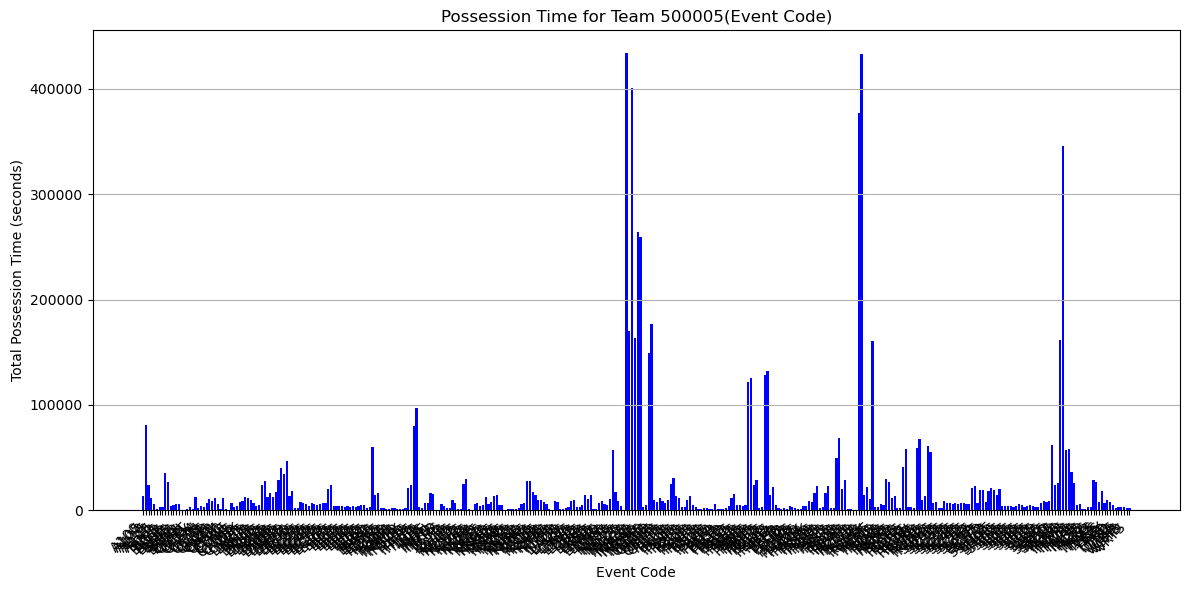

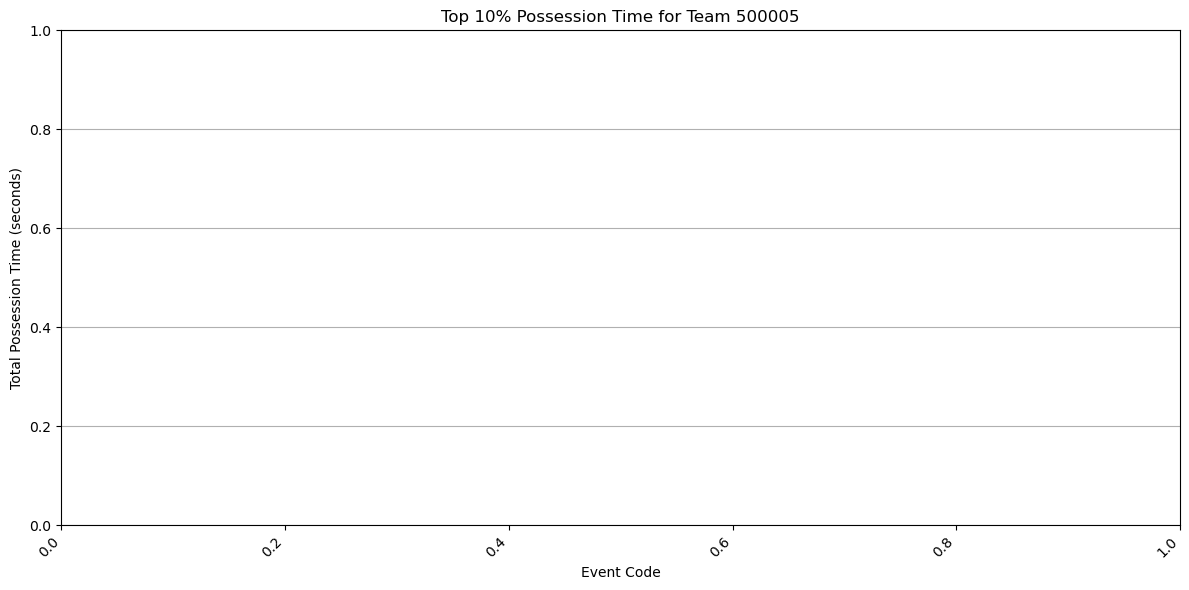

In [209]:
def get_players_possession(df_possession): 
    # Group by MatchId, InPossessionClubId, and InPossessionPlayerId-each player
    players_possession = df_possession.groupby(['MatchId', 'InPossessionClubId', 'InPossessionPlayerId']).agg(
        TotalPossessionTime=('PossessionSecs', 'sum'),
        TotalOpponentPossessionTime=('OppPossessionSecs', 'sum'),
        AverageFieldPositionX=('XmPhysical', 'mean'),
        AverageFieldPositionY=('YmPhysical', 'mean'),
        AverageScore=('Score', 'mean'),
        AverageOppScore=('OppScore', 'mean'),
        PossessionCount=('PossessionSecs', 'count')
    ).reset_index()
    players_possession['MatchId'] = players_possession['MatchId'].astype(int)
    players_possession['InPossessionClubId'] = players_possession['InPossessionClubId'].astype(int)
    players_possession['InPossessionPlayerId'] = players_possession['InPossessionPlayerId'].astype(int)                        
    float_cols = ['TotalPossessionTime', 'TotalOpponentPossessionTime', 'AverageFieldPositionX', 
                  'AverageFieldPositionY', 'AverageScore', 'AverageOppScore', 'PossessionCount']
    players_possession[float_cols] = players_possession[float_cols].astype(float)
    players_possession = players_possession.sort_values(by='InPossessionPlayerId') #sort by playerID
    return players_possession
df_players_possession = get_players_possession(df_possession)

#display
print(df_players_possession.head())

       MatchId  InPossessionClubId  InPossessionPlayerId  TotalPossessionTime  \
3354  21111143              500001                500002            239731.09   
4337  21111184              500001                500002            448133.57   
4169  21111173              500001                500002            345060.35   
1315  21111063              500001                500002            519581.45   
6135  21111251              500001                500002            287799.48   

      TotalOpponentPossessionTime  AverageFieldPositionX  \
3354                    231705.86              51.080789   
4337                    460463.72              58.346429   
4169                    349217.42              60.771854   
1315                    504864.36              55.740948   
6135                    299247.64              50.251770   

      AverageFieldPositionY  AverageScore  AverageOppScore  PossessionCount  
3354              38.138947      9.000000        10.557895            380.

In [233]:
df_possession.to_csv('/Users/june/Downloads/24T3/data3001/possession_data_with_features.csv', index=False)
df_overall_possession.to_csv('/Users/june/Downloads/24T3/data3001/team_possession_data.csv', index=False)
df_players_possession.to_csv('/Users/june/Downloads/24T3/data3001/player_possession_data.csv', index=False)

## 3. Feature engineerings
_per_team?
per team OR per player, process feature engineering based on the filtered csv above from here.

In [172]:
csv_path2 = '/Users/june/Downloads/24T3/data3001/team_possession_data.csv'
pt_possession = pd.read_csv(csv_path2, low_memory=False)

### 3-1. Possession Indicator 
all the teams recored in any csv file is the one with possession on that event, so no need to get a Possession Indicator since the team with its ID recorded with the event is the team with possession indicator being 1.

### 3-2. Time of Possession Segmentatibon
Breaking down "possession" into segments of start and end of possession PER EVENT to track continuous possession phases.
To calculate WPA or EPA, measure the possession before each event happens.

In [188]:
#for each team, calc time..

# Detect changes in possession
pt_possession['PreviousPossessionClubId'] = pt_possession['InPossessionClubId'].shift(1)
pt_possession['PossessionSwitched'] = pt_possession['InPossessionClubId'] != pt_possession['PreviousPossessionClubId']

# Create possession segments by detecting when possession switches
pt_possession['PossessionTimeStart'] = df_possession['PossessionSwitched'].apply(lambda x: 1 if x else 0).cumsum()

# possession time = time when event happend - starting time 
# standardize Time Min:Sec and do the subtraction to get the duration
pt_possession['PossessionStartSecs'] = pt_possession.groupby('PossessionTimeStart')['ElapsedMins'].transform('first') * 60 + pt_possession.groupby('PossessionTimeStart')['ElapsedSecs'].transform('first')
pt_possession['PossessionEndSecs'] = pt_possession.groupby('PossessionTimeStart')['ElapsedMins'].transform('last') * 60 + pt_possession.groupby('PossessionTimeStart')['ElapsedSecs'].transform('last')
pt_possession['PossessionDuration'] = pt_possession['PossessionEndSecs'] - pt_possession['PossessionStartSecs']

#for use
Possession_duration = pt_possession['PossessionDuration']

KeyError: 'Column not found: ElapsedMins'

## 3-3. Overall possession time per team OR player ??

In [ ]:
#Overall possession time per team, player??
df_overall_possession = get_overall_possession(df_possession)
df_players_possession = get_players_possession(df_possession)poss


### 3-4. field position while possession
 A rugby league pitch (or field) is 68 m (74 yards) wide and 112–122 m (122–133 yards) long. 
The try lines (or goal lines) stand 100 m (110 yards) apart. On each one is a goal post that is 5.5 m (6 yards) wide 
and at least 16 m (17 yards) high, with a crossbar set 3 m (3.3 yards) above the ground. (reference by wikipedia)/

Being normalized and linked to the probability of scoring from various field positions in a game.

In [148]:
def field_position_normalization(df_possession):
    df_possession['XmNormalized'] = df_possession['XmPhysical'] / 112  # Normalize by field length
    df_possession['YmNormalized'] = df_possession['YmPhysical'] / 68   # Normalize by field width
    
    return df_possession
df_possession_field_position = field_position_normalization(df_possession)

In [120]:
# 6. Possession Time Momentum: # readme feedback-Create a derived feature that measures shifts in momentum by tracking how long each team has possession before switching. This could be key in identifying turning points in the game.
df_possession['MomentumChange'] = df_possession['PossessionSwitched'].apply(lambda x: 1 if x else 0).cumsum()
df_possession['TimeSinceMomentumShift'] = df_possession.groupby('MomentumChange')['PossessionSecs'].cumsum()

# Function to get player-level possession data (already implemented in your get_players_possession function)
def get_players_possession(df_possession): 
    # Group by MatchId, InPossessionClubId, and InPossessionPlayerId-each player
    players_possession = df_possession.groupby(['MatchId', 'InPossessionClubId', 'InPossessionPlayerId']).agg(
        TotalPossessionTime=('PossessionSecs', 'sum'),
        TotalOpponentPossessionTime=('OppPossessionSecs', 'sum'),
        AverageFieldPositionX=('XmPhysical', 'mean'),
        AverageFieldPositionY=('YmPhysical', 'mean'),
        AverageScore=('Score', 'mean'),
        AverageOppScore=('OppScore', 'mean'),
        PossessionCount=('PossessionSecs', 'count')
    ).reset_index()
    players_possession['MatchId'] = players_possession['MatchId'].astype(int)
    players_possession['InPossessionClubId'] = players_possession['InPossessionClubId'].astype(int)
    players_possession['InPossessionPlayerId'] = players_possession['InPossessionPlayerId'].astype(int)

    float_cols = ['TotalPossessionTime', 'TotalOpponentPossessionTime', 'AverageFieldPositionX', 'AverageFieldPositionY', 'AverageScore', 'AverageOppScore', 'PossessionCount']
    players_possession[float_cols] = players_possession[float_cols].astype(float)
    players_possession = players_possession.sort_values(by='InPossessionPlayerId') # Sort by playerID

    return players_possession

df_players_possession = get_players_possession(df_possession)


In [122]:
print(df_possession.head())

      MatchId    ClubId  OppositionId  SeqNumber  Half  ElapsedMins  \
0  21111011.0  500005.0      500021.0         10     1            0   
1  21111011.0  500021.0      500005.0        100     1            0   
2  21111011.0  500005.0      500021.0       1000     1            6   
3  21111011.0  500021.0      500005.0      10000     2           37   
4  21111011.0  500021.0      500005.0      10001     2           37   

   ElapsedSecs  PossessionSecs  OppPossessionSecs  TotalPossessionSecs  \
0            4            4.00               0.00                 4.00   
1           28           24.06               4.00                28.06   
2           34           92.46             179.28               271.74   
3            7         1512.52            1378.58              2891.10   
4            7         1512.53            1378.58              2891.11   

  EventCode              EventName  Set  Tackle  InPossessionClubId  \
0      ENPO       Possession - end    1       0          